In [1]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

### Params
---
### Risize Image
- **risize_factor**: Resize the Edge Image

### Line Approx:
- **fixed_epsilon**: Fixed value for epsilon (is only used if use_dynamic_epsilon == False)
- **use_dynamic_epsilon**: Controlls if dynamic or fixed epsilon are used
- **epsilon_factor**: The Epsilon Factor, which is multiplied with the Contour Length
- **max_epsilon**: The max epsilon value for dynamic epsilon
- **min_epsilon**: The min epsilon value for dynamic epsilon

### GCODE:
- **z_safe_hight**: The save height
- **z_working_hight**: The working height (not drawing)
- **z_depth**: The height when drawing
- **z_feed**: The feed for the z Axis
- **xy_feed**: The feed for the x and y axis
- **spindle_speed**: The speed of the Spindle

In [2]:
# Image Preprocessing Params
blurr_kernel_size = 5
risize_factor = 2

# Line Approximation Params
fixed_epsilon = 2.2

use_dynamic_epsilon = False
epsilon_factor = 0.02
max_epsilon = 2.5
min_epsilon = 1.5

# GCODE Params
z_safe_hight = 10.0
z_working_hight = 0.5
z_depth = 3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000
# Maximaler Vorschub ist ca. 3000 (immer bei G0) (3000mm pro Minute)

## 1. Image Preprocessing
---
**Goal:** <br>
M03 S24000 <br>
G00 Z10.0 <br>
6##################################### <br>
G00 X7 Y0 <br>
G00 Z0.5 <br>
G00 Z0 <br>
G01 Z-3 F500 <br>
G01 X1 Y6 F1000 <br>
G01 X4 Y9 <br>
G00 Z0.5 <br>
#########################End <br>
G00 Z10.0 <br>
G00 X0 Y0 <br>
M05 <br>
M30 <br>



In [3]:
preloaded_images = None
with open("../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

# Rauschen eliminieren
blurred = cv2.GaussianBlur(gray, (blurr_kernel_size, blurr_kernel_size), 0)

# Canny-Kanten-Detektor
edges = cv2.Canny(blurred, 100, 200)

# Resize Edge Image
resized_image = cv2.resize(edges, (edges.shape[1] // risize_factor, edges.shape[0] // risize_factor))

edges = resized_image

## 2. Line Approximation
---

In [4]:
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

def getDynamicEpsilon(contour, epsilon_factor, max_epsilon, min_epsilon):
       # Area könnte auch verwendet werden
       epsilon_tmp = epsilon_factor * cv2.arcLength(contour, True)
       
       if epsilon_tmp <= max_epsilon and epsilon_tmp >= min_epsilon:
              return epsilon_tmp
       elif epsilon_tmp > max_epsilon:
              return max_epsilon
       elif epsilon_tmp < min_epsilon:
              return min_epsilon


edge_approximations = []

for i in range(len(contours)):
       epsilon = fixed_epsilon if use_dynamic_epsilon == False else getDynamicEpsilon(contours[i], epsilon_factor, max_epsilon, min_epsilon)

       edge_approx = cv2.approxPolyDP(contours[i], epsilon, True)
       
       # remove last element if it is already in contour
       if edge_approx[-1] in edge_approx[:len(edge_approx)-2]:
              edge_approx = edge_approx[:-1]
       
       edge_approximations.append(edge_approx)

## 3. Generate GCODE
---

In [5]:
gcode_lines = []

# Drehgeschwindigkeit und initiale Höhe festlegen
gcode_lines += [
    f'M03 S{spindle_speed}', 
    f'G00 Z{z_safe_hight}'
]

# GCODE für die Kontouren
for i, edge_approx in enumerate(edge_approximations):
    gcode_lines += [
        f'######## Contour {i+1} ########',
        f'G00 X{edge_approx[0][0][0]} Y{edge_approx[0][0][1]}',
        f'G00 Z{z_working_hight}' if i == 0 else None,
        'G00 Z0',
        f'G01 Z-3 F{z_feed}',
        f'G01 X{edge_approx[1][0][0]} Y{edge_approx[1][0][1]} F{xy_feed}' if len(edge_approx) > 1 else None,
        *[f'G01 X{edge[0][0]} Y{edge[0][1]}' for edge in edge_approx[2:]],
        f'G00 Z{z_working_hight}'
    ]

# Fräßkopf zu initialer Position zurückbewegen
gcode_lines += [
    '######## End ########',
    f'G00 Z{z_safe_hight}',
    'G00 X0 Y0',
    'M05',
    'M30'
]

# None Elemente entfernen und GCODE erstellen
gcode = '\n'.join([line for line in gcode_lines if line != None])

# Save the G-code to a file
with open('gcode.tap', "w") as f:
    f.writelines(gcode)

# Print GCODE Stats
gcode_stats = [
    'Generated GCODE',
    f'Amount of Contours: {len(edge_approximations)}',
    f'Amount of Lines: {len(gcode_lines)}',
]

print('\n'.join(gcode_stats))

Generated GCODE
Amount of Contours: 1426
Amount of Lines: 11194


## 3. Visulize Image
---

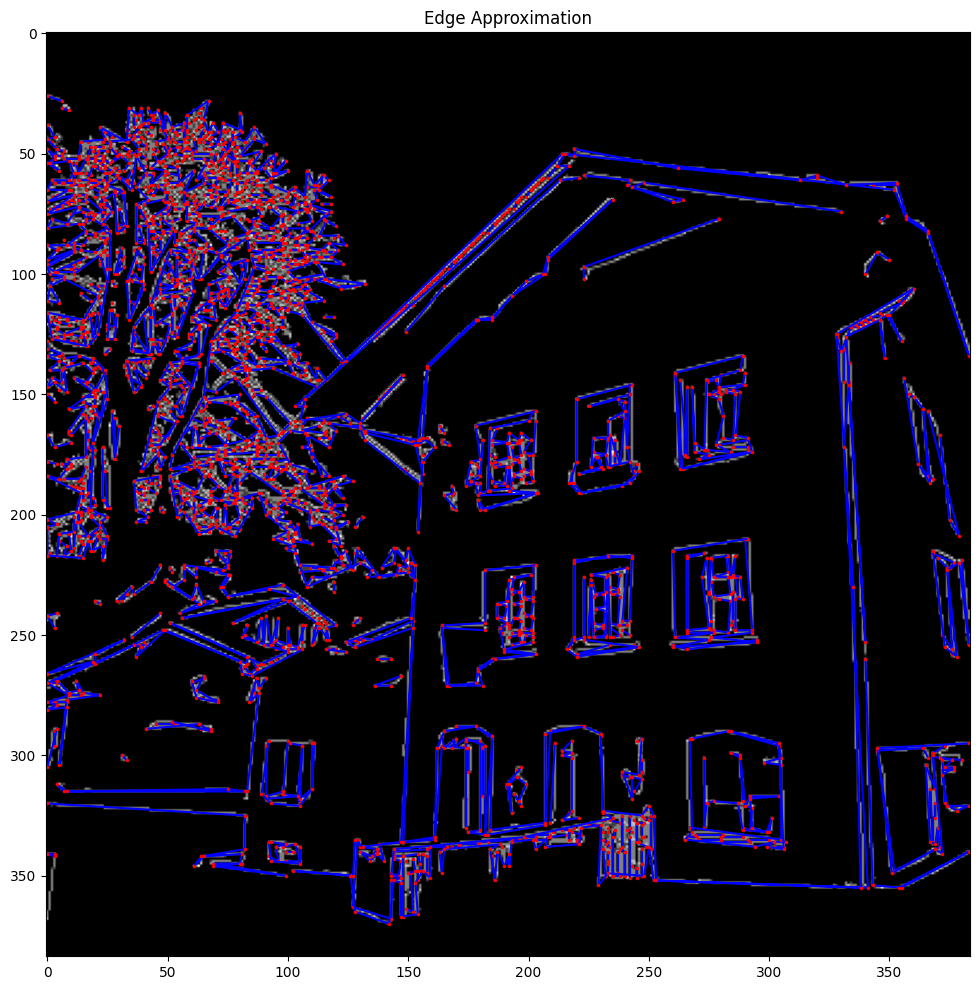

In [6]:
# Plot des Edge-Bildes
plt.figure(figsize=(16, 12))
plt.imshow(edges, cmap='gray')

# Plot der approximierten Kanten als Linien mit blauer Farbe
for edge_approx2 in edge_approximations:
    x_approx = edge_approx2[:, :, 0].flatten()
    y_approx = edge_approx2[:, :, 1].flatten()
    plt.plot(x_approx, y_approx, color='blue')

    # Plot der Eckpunkte als rote Punkte
    plt.plot(x_approx, y_approx, 'ro', markersize=1.5)

plt.title('Edge Approximation')

# Anpassung der Achsenskalierung
plt.axis('scaled')

# Anzeigen des Diagramms
plt.show()

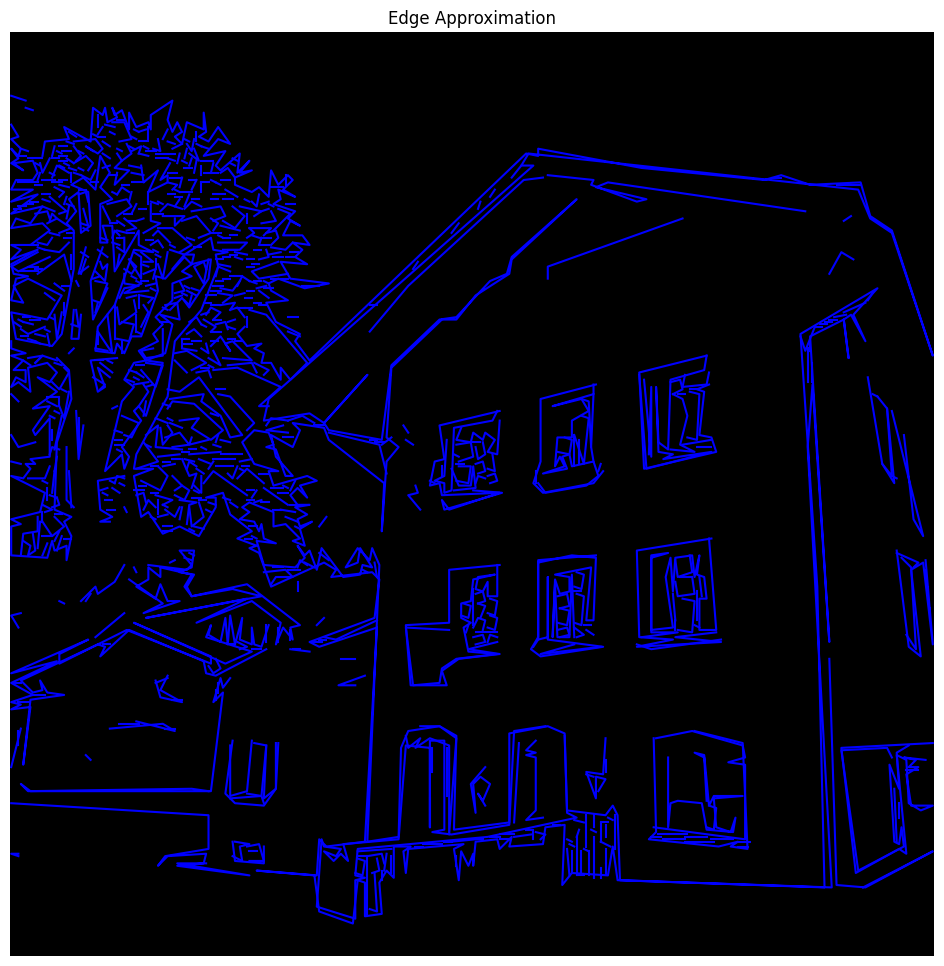

In [10]:
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(np.zeros_like(edges, dtype=np.uint8), cv2.COLOR_GRAY2BGR), cmap='gray')

for edge_approx2 in edge_approximations:
    x_approx = edge_approx2[:, :, 0].flatten()
    y_approx = edge_approx2[:, :, 1].flatten()
    plt.plot(x_approx, y_approx, color='blue')

plt.axis('off')
plt.show()

(-19.150000000000002, 402.15, 8.8, 387.2)

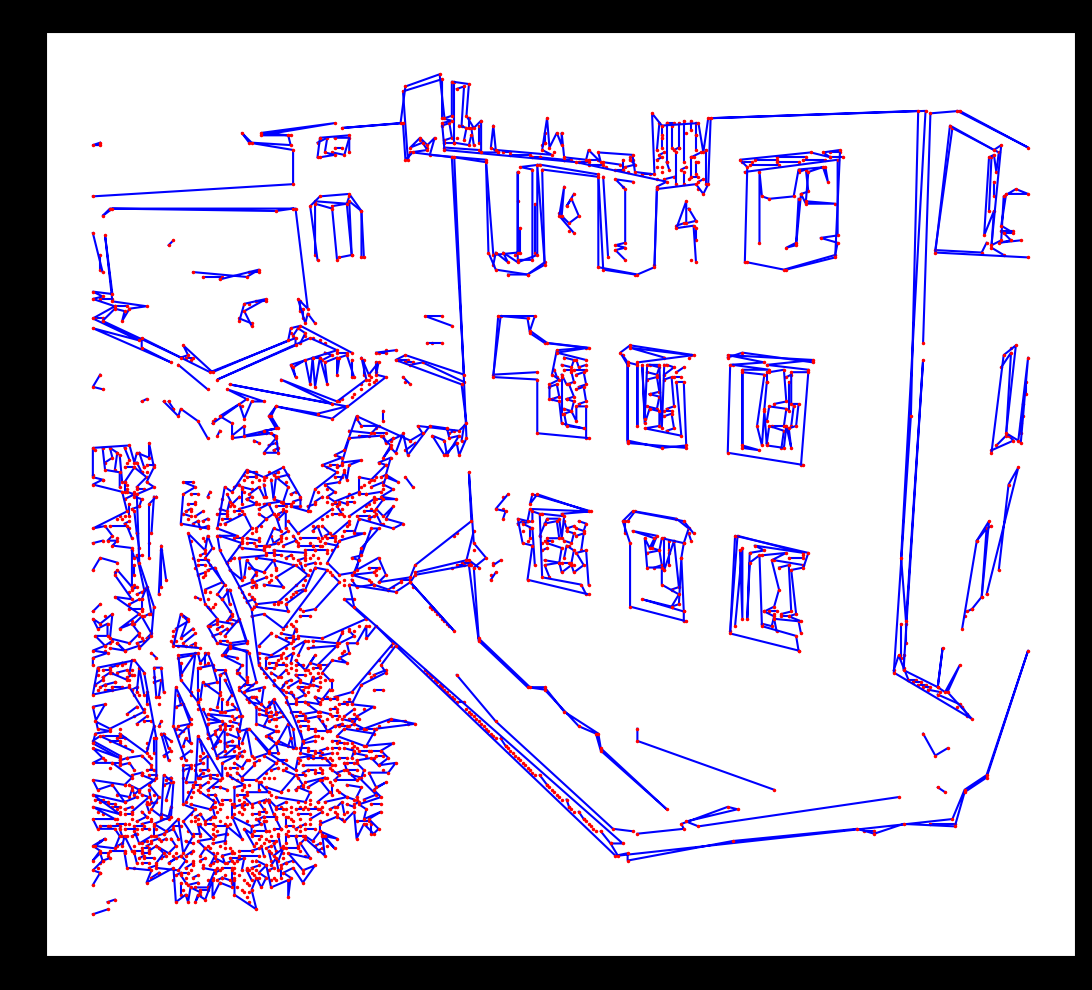

In [7]:
import matplotlib.pyplot as plt

# Plot des Edge-Bildes ohne Anzeige
fig, ax = plt.subplots(figsize=(16, 12), facecolor='black')

# Plot der approximierten Kanten als Linien mit blauer Farbe
for edge_approx2 in edge_approximations:
    x_approx = edge_approx2[:, :, 0].flatten()
    y_approx = edge_approx2[:, :, 1].flatten()
    ax.plot(x_approx, y_approx, color='blue')

    # Plot der Eckpunkte als rote Punkte
    ax.plot(x_approx, y_approx, 'ro', markersize=1.5)

ax.set_title('Edge Approximation')

# Anpassung der Achsenskalierung
ax.axis('scaled')
